# Unsupervised Bayesian Anomaly Detection Using Beta Binomial Distribution

This notebook goes through an example of how one could use a bayesian framework to do unsupervised anomaly detection. In this particular example, we will consider medical coding behaviors from doctor office visits for evaluation and management services.

**Note that all data and results in this notebook are synthetic!** To see the data generation process, please see `/data/generate_data.ipynb`.

What is an E/M code?
1. E/M coding is the process by which physician-patient encounters are translated into five digit CPT codes to facilitate billing.
2. There are many attributes of the encounter that factor into the level of coding
    1. History
    2. Examination
    3. Medical decision making
    4. Counseling
    5. Coordination of care
    6. Nature of presenting problem
    7. Time (spent with patient)
    
The first three (history, examination, medical decision making) are considered the key components that determine the level of an E/M code.

# Setup

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import sqlalchemy as sa
import sqlparse
from random import randint
import statsmodels.formula.api as sm

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines

sys.path.append('../../../')
import analysis as an
import em_codes as em

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
matplotlib.rcParams['figure.figsize'] = (10, 6)

In [3]:
# Create DB Engine
db_url = 'postgres://localhost:5432/VincentLa'
db_engine = sa.create_engine(db_url)
conn = db_engine.connect()
metadata = sa.MetaData(bind=conn)

In [4]:
# Define EM code groups
OFFICE_EST_PATIENT = [1, 2, 3, 4, 5]

In [5]:
claim_lines = sa.Table(
    'claim_lines',
    metadata,
    schema='tutorial_data_ingest',
    autoload=True
)

Read in the data frame so we can explore!

In [6]:
claims = pd.read_sql(em.get_claims_base_data(claim_lines, OFFICE_EST_PATIENT), conn)

Run the analysis, we will look at the output of this later in the notebook!

In [7]:
result_output, distribution_values_output = an.run(conn, claim_lines, OFFICE_EST_PATIENT)

# Exploration

Let's explore the data intuitively!

In [8]:
claims.head()

,personid,servicing_provider_npi,procedure_code,procedure_name,procedure_name_array
0,11324,Dr. Darlene Allen,5,"Evaluation and Management, Highest Intensity","[Evaluation and Management, Highest Intensity]"
1,1633,Dr. Darlene Allen,5,"Evaluation and Management, Highest Intensity","[Evaluation and Management, Highest Intensity]"
2,18100,Dr. Darlene Allen,4,"Evaluation and Management, High Intensity","[Evaluation and Management, High Intensity]"
3,19251,Dr. Darlene Allen,5,"Evaluation and Management, Highest Intensity","[Evaluation and Management, Highest Intensity]"
4,16174,Dr. Darlene Allen,5,"Evaluation and Management, Highest Intensity","[Evaluation and Management, Highest Intensity]"


How many patient-doctor interactions are there?

In [9]:
claims.shape

(102246, 5)

What are the different types of procedures in this data set?

In [10]:
claims[['procedure_code', 'procedure_name']].drop_duplicates()

,procedure_code,procedure_name
0,5,"Evaluation and Management, Highest Intensity"
2,4,"Evaluation and Management, High Intensity"
9,3,"Evaluation and Management, Medium Intensity"
15,1,"Evaluation and Management, Lowest Intensity"
25,2,"Evaluation and Management, Second Lowest Inten..."


How many patients do doctors see?

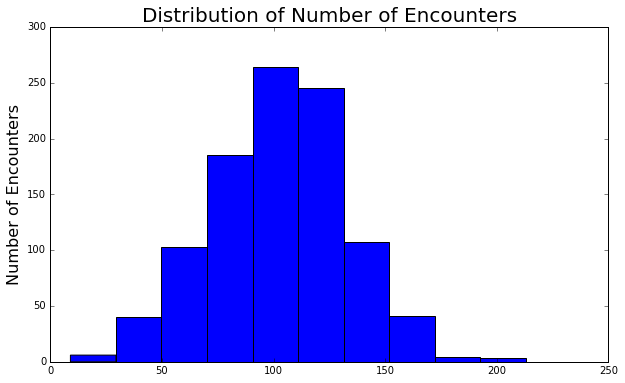

In [11]:
number_of_encounters = claims.groupby('servicing_provider_npi').size()
plt.hist(number_of_encounters)
plt.ylabel('Number of Encounters', fontsize=16)
plt.title('Distribution of Number of Encounters', fontsize=20)
plt.show()

Let's now look at the overall distribution of intensities

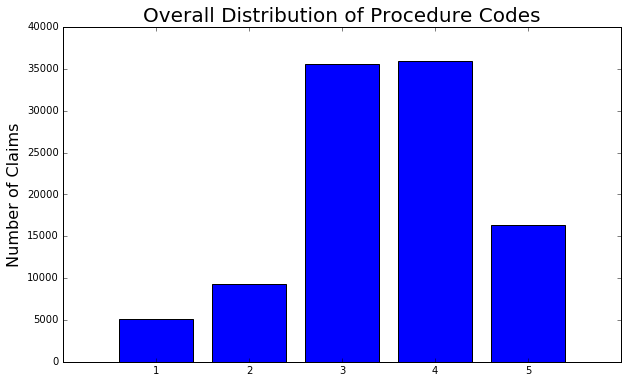

In [12]:
codes = claims.groupby('procedure_code').size().index
number_of_encounters = claims.groupby('procedure_code').size()
plt.bar(codes, number_of_encounters, align='center')
plt.xticks(codes, codes)
plt.ylabel('Number of Claims', fontsize=16)
plt.title('Overall Distribution of Procedure Codes', fontsize=20)
plt.show()

Let's look at the distribution of proportion of level 5 procedure codes billed by a provider.

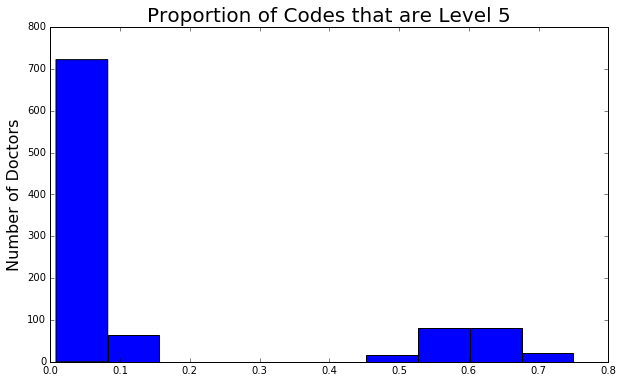

In [13]:
plt.hist(result_output['All'].pct_high_encounters)
plt.ylabel('Number of Doctors', fontsize=16)
plt.title('Proportion of Codes that are Level 5', fontsize=20)
plt.show()

# Results

Let's actually look at our results now! Things we will cover in this section are:
1. What is the output of the bayesian implementation?
2. What is the expected value of the proportion of level 5 codes billed for each doctor?
3. What is the probability that this doctor is "above average"?

In [14]:
results = result_output['All']

Notice the relationship between `regressed_prob` and `naive_perc` and how it's dependent on the number of observations.

In [28]:
results.loc[(results.pct_high_encounters >= 0.7)]

,observations,successes,pct_high_encounters,naive_perc,group,a,b,regressed_prob,prob_above_average
servicing_provider_npi,,,,,,,,,
Dr. Hattie Turner,44.0,33.0,0.750000,0.750000,All,33.623519,13.867835,0.707992,0.98382
Dr. Chad Trott,48.0,34.0,0.708333,0.708333,All,34.623519,16.867835,0.672414,0.97753
Dr. Catherine Kiely,72.0,52.0,0.722222,0.722222,All,52.623519,22.867835,0.697080,0.98221
Dr. Howard Thomas,51.0,36.0,0.705882,0.705882,All,36.623519,17.867835,0.672098,0.97673
Dr. Cynthia Simmons,130.0,91.0,0.700000,0.700000,All,91.623519,41.867835,0.686363,0.98083
Dr. Debrah Mccray,90.0,63.0,0.700000,0.700000,All,63.623519,29.867835,0.680528,0.98008
Dr. Charles Neufeld,90.0,63.0,0.700000,0.700000,All,63.623519,29.867835,0.680528,0.97973
Dr. Rachael Gilliam,141.0,99.0,0.702128,0.702128,All,99.623519,44.867835,0.689477,0.98188


In [29]:
results.sort_values(['prob_above_average'], ascending=False).head(20)

,observations,successes,pct_high_encounters,naive_perc,group,a,b,regressed_prob,prob_above_average
servicing_provider_npi,,,,,,,,,
Dr. Hattie Turner,44.0,33.0,0.750000,0.750000,All,33.623519,13.867835,0.707992,0.98382
Dr. Catherine Kiely,72.0,52.0,0.722222,0.722222,All,52.623519,22.867835,0.697080,0.98221
Dr. Rachael Gilliam,141.0,99.0,0.702128,0.702128,All,99.623519,44.867835,0.689477,0.98188
Dr. Cynthia Simmons,130.0,91.0,0.700000,0.700000,All,91.623519,41.867835,0.686363,0.98083
Dr. Erna Tripp,124.0,86.0,0.693548,0.693548,All,86.623519,40.867835,0.679446,0.98009
Dr. Debrah Mccray,90.0,63.0,0.700000,0.700000,All,63.623519,29.867835,0.680528,0.98008
Dr. Charles Neufeld,90.0,63.0,0.700000,0.700000,All,63.623519,29.867835,0.680528,0.97973
Dr. Beverly Smith,106.0,73.0,0.688679,0.688679,All,73.623519,35.867835,0.672414,0.97958
Dr. Charles Haynes,86.0,60.0,0.697674,0.697674,All,60.623519,28.867835,0.677423,0.97901


# Visualization

Let's make some visualizations!

In this section, we will actually visualize the distribution of the posterior, p, that we are estimating. That is, we will visualize the distribution of our posterior opinion of the proportion of level 5 codes a provider will bill.

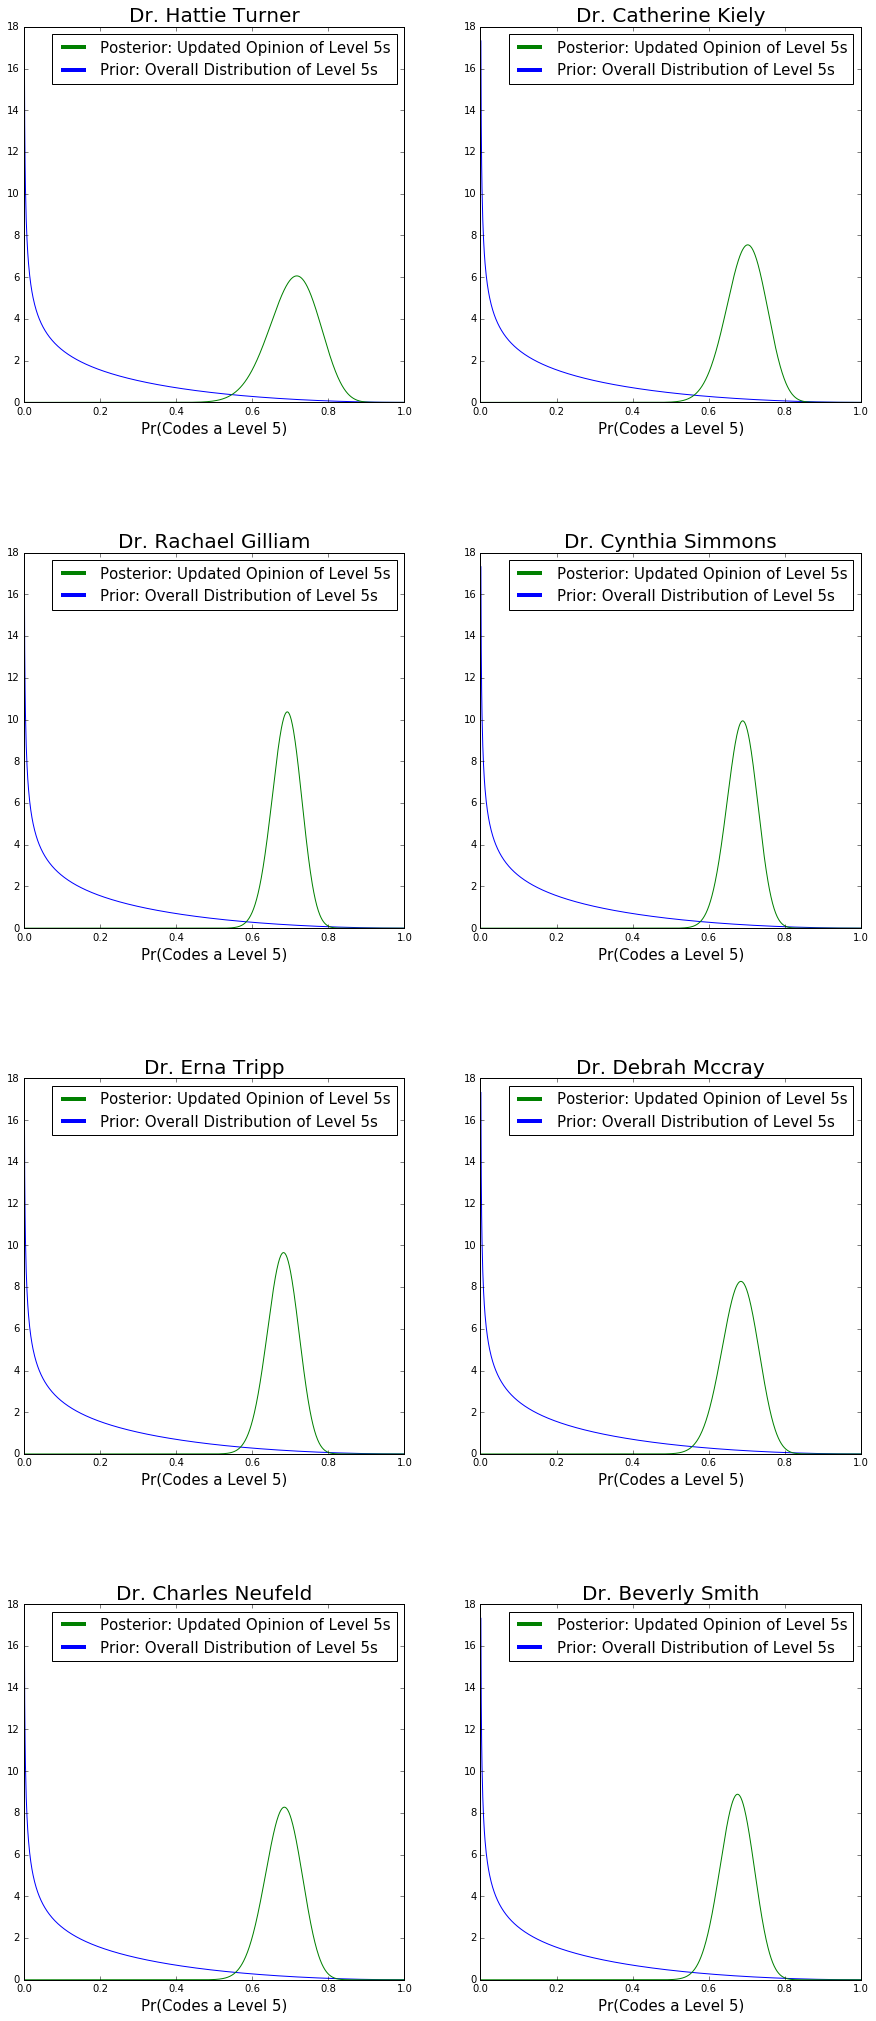

In [20]:
fig = plt.figure(figsize=(15, 35))
gs1 = gridspec.GridSpec(4, 2)
gs1.update(hspace=.4)
ax_list = [fig.add_subplot(ss) for ss in gs1]

distribution_values = distribution_values_output['All']

npis = result_output['All'].sort_values(['prob_above_average'], ascending=False).head(8).index
for i,npi in enumerate(npis):
    ax=ax_list[i]
    ax.plot(distribution_values['prior'][0], distribution_values['prior'][1])
    ax.plot(distribution_values[npi][0], distribution_values[npi][1])
    ax.set_title(npi, fontsize=20)
    ax.set_xlabel('Pr(Codes a Level 5)', fontsize=15)
    posterior = mlines.Line2D([], [], color='green', label='Posterior: Updated Opinion of Level 5s', linewidth=4)
    prior = mlines.Line2D([], [], color='blue', label='Prior: Overall Distribution of Level 5s', linewidth=4)

    ax.legend(handles=[posterior, prior], fontsize=15)

# Validating Results

How do we validate the results of our analysis? For example, one question we might have is how do we know whether the results of our analysis are due to just spurious noise, or if there's real signal here?

In this section, we talk about one very intuitive approach to validate our results. As this is unsupervised learning, it is not possible to do a traditional 'cross-validation' approach. However, one can do something similar in spirit. Below, we split out data set in half randomly by taking separating all even `personid` from odd `personid`. We then run our analysis over each of the data sets separately and return the ranking of providers in each. We then correlate the rankings obtained in the separate data sets. If rankings are highly correlated, that's decent evidence that there is real signal. If the rankings are not correlated, one might conclude that results are really due to statistical noise.

In [21]:
columns = [
    claim_lines.c.personid,
    claim_lines.c.servicing_provider_npi,
    claim_lines.c.procedure_code,
    claim_lines.c.procedure_name
]
claim_lines_1 = (
    sa.select(columns).
    select_from(claim_lines).
    where(claim_lines.c.personid % 2 == 1)
).correlate(None).alias('claim_lines_1')

claim_lines_2 = (
    sa.select(columns).
    select_from(claim_lines).
    where(claim_lines.c.personid % 2 == 0)
).correlate(None).alias('claim_lines_1')

In [22]:
result_output_1, distribution_values_output_1 = an.run(conn, claim_lines_1, OFFICE_EST_PATIENT)
result_output_2, distribution_values_output_2 = an.run(conn, claim_lines_2, OFFICE_EST_PATIENT)

In [23]:
output1 = result_output_1['All']
output2 = result_output_2['All']

In [24]:
combined = output1.merge(output2, left_index=True, right_index=True)

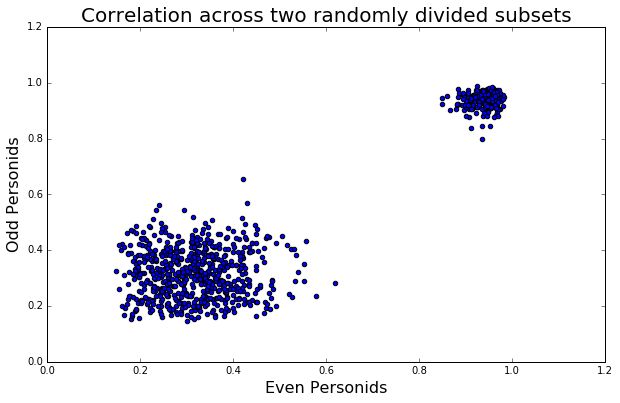

In [35]:
plt.scatter(combined.prob_above_average_x, combined.prob_above_average_y)
plt.ylabel('Odd Personids', fontsize=16)
plt.xlabel('Even Personids', fontsize=16)
plt.title('Correlation across two randomly divided subsets', fontsize=20)
plt.show()

We plot the probability above average returned for each doctor across the two randomly divided subsets (using even/odd personids). There are two main clusters (which is mostly the result of the data generation process) that make it pretty apparent to see the pattern. In the data generation process there are only 2 types of providers, upcoders and non-upcoders. The cluster in the bottom left are the non-upcoders. Notice how the probability above average in one of the randomly divided subsets for each provider is basically uncorrelated with their score in the other data set.

However, notice that for the data points in the top right cluster, which represent the upcoders, the correlation is a lot tighter and much less spread. This provides some evidence that these providers actually are associated with more level 5 codes as opposed to the pattern being generated by random noise.